In [1]:
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import numpy as np 
import pandas as pd 
from scipy import linalg
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

from sklearn.model_selection import KFold
np.random.seed(2147483648)
import plotly.io as pio
pio.renderers.default='browser'
import plotly.graph_objects as go


In [2]:
two_composite_filtered = pd.read_csv("Curated_data/two_composite_filtered.csv", low_memory=False)


C:\Users\23478671\AppData\Local\Temp\ipykernel_10036\372700988.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\23478671\AppData\Local\Temp\ipykernel_10036\372700988.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\23478671\AppData\Local\Temp\ipykernel_10036\372700988.py:38: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

- Iteration 0, MSE: 0.618


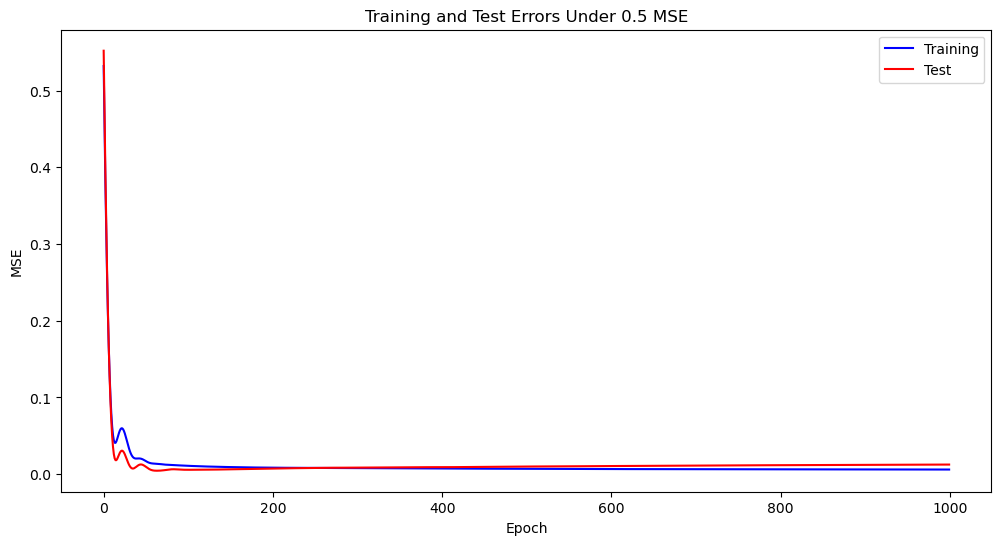

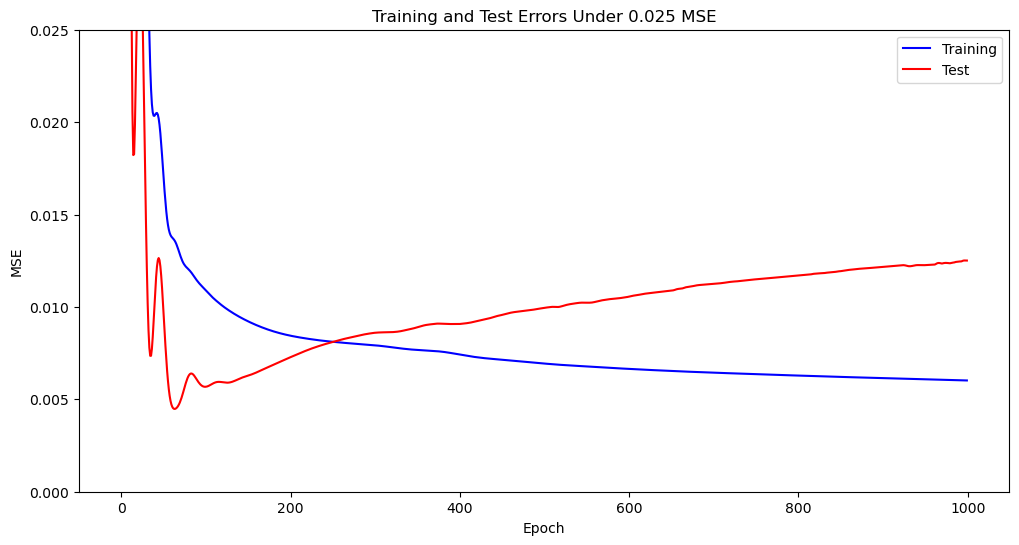

In [3]:
#Subset data for each mineral
mineral = 'Density_gcm3'
two_composite_filtered = two_composite_filtered.loc[:,["Name", 'X', 'Y', 'Z', mineral]]
two_composite_1mineral = two_composite_filtered.dropna(subset=[mineral])

np.random.seed(2147483648)

# Define the specific hole you want to predict for
hole_name = 'KV-NME001'


# Filter the data for the selected hole
hole_data = two_composite_1mineral[two_composite_1mineral['Name'] == hole_name]


# Define the columns to normalize
columns_to_normalize = ['X', 'Y', 'Z']  # Add all columns you want to normalize

min_values = hole_data[columns_to_normalize].min()

for column in columns_to_normalize:
    hole_data[column] = hole_data[column] - min_values[column]

# Calculate the minimum and maximum values from the entire dataset
min_values = hole_data[columns_to_normalize].min().min()
max_values = hole_data[columns_to_normalize].max().max()

# Scale the data to (0, 1) using the calculated minimum and maximum values
for column in columns_to_normalize:
    hole_data[column] = (hole_data[column] - min_values) / (max_values - min_values)


# Create a MinMaxScaler instance
scaler = MinMaxScaler()


# Fit the scaler to your data and transform the specified columns
hole_data.loc[:, [mineral]] = scaler.fit_transform(hole_data.loc[:, [mineral]])


# Extract the features (X and Y coordinates) and target (mineral) for the selected hole
x = hole_data[['X','Y', 'Z']].values#[:,np.newaxis] makes the second dimension explicit
y = hole_data[mineral].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit

x = torch.tensor(x)
y = torch.tensor(y)
x = x.to(torch.float32)
y = y.to(torch.float32)

# Determine the size of the test set (e.g., 20% of the data)
test_size = int(0.2 * len(x))

# Generate random indices for the test set
test_indices = np.random.choice(len(x), size=test_size, replace=False)

# Create train and test sets based on the indices
x_train = x[np.setdiff1d(np.arange(len(x)), test_indices)]
y_train = y[np.setdiff1d(np.arange(len(y)), test_indices)]

x_test = x[np.sort(test_indices)]
y_test = y[np.sort(test_indices)]




# Split the data into train and test sets
test_size = int(0.2 * len(x))
test_indices = np.random.choice(len(x), size=test_size, replace=False)
x_train = x[np.setdiff1d(np.arange(len(x)), test_indices)]
y_train = y[np.setdiff1d(np.arange(len(y)), test_indices)]
x_test = x[np.sort(test_indices)]
y_test = y[np.sort(test_indices)]

model = nn.Sequential(
    nn.Linear(in_features=3, out_features=300),
    nn.ReLU(),
    nn.Linear(in_features=300, out_features=1)
)

mse_loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []  # To store training losses during training
test_losses = []   # To store test losses during training

for step in range(1000):
    pre = model(x_train)
    mse = mse_loss(pre, y_train)
    cost = mse

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    pre_train = model(x_train)
    mse_train = mse_loss(pre_train, y_train)
    train_losses.append(mse_train.item())

    # Evaluate the model on the test set
    pre_test = model(x_test)
    mse_test = mse_loss(pre_test, y_test)
    test_losses.append(mse_test.item())

    if step % 1000 == 0:
        print(f'- Iteration {step}, MSE: {mse.item():.3f}')


# Create a plot showing only values under 0.2 on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training', color='blue')
plt.plot(test_losses, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
#plt.ylim(0, 0.5)  # Set the y-axis limit to filter values under 0.05
plt.legend()
plt.title('Training and Test Errors Under 0.5 MSE')
plt.show()



# Create a plot showing only values under 0.05 on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training', color='blue')
plt.plot(test_losses, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim(0, 0.025)  # Set the y-axis limit to filter values under 0.05
plt.legend()
plt.title('Training and Test Errors Under 0.025 MSE')
plt.show()



# Define a grid of points for prediction (including X, Y, and Z)
x_grid = np.linspace(x[:, 0].min(), x[:, 0].max(), 100)
y_grid = np.linspace(x[:, 1].min(), x[:, 1].max(), 100)
z_grid = np.linspace(x[:, 2].min(), x[:, 2].max(), 100)
xyz_grid = np.array(np.meshgrid(x_grid, y_grid, z_grid)).T.reshape(-1, 3)

# Make predictions for the grid
predictions = model(torch.tensor(xyz_grid, dtype=torch.float32))

# Reshape the predictions to match the grid shape
predictions = predictions.data.numpy().reshape(100, 100, 100)
 
fig = go.Figure(data=[
    go.Volume(
        x=x_grid,
        y=y_grid,
        z=z_grid,
        value=predictions,
        opacity=0.6,
        surface_count=170,
        colorscale='viridis',
    ),
])


# Add a scatter plot for test data points
fig.add_trace(go.Scatter3d(
    x=x_test.data.numpy()[:, 0],
    y=x_test.data.numpy()[:, 1],
    z=x_test.data.numpy()[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        #color=y_test.data.numpy().ravel(),
        #colorscale='viridis',  # Adjust the color scale
        #colorbar=dict(title=mineral),
        opacity=0.7,
    ),
    name='Test set'
))

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='data',
    ),
)

fig.update_layout(title=f'{mineral} Prediction in 3D')
fig.show()



In [4]:


#Subset data for each mineral
mineral = 'Density_gcm3'
two_composite_filtered = two_composite_filtered.loc[:,["Name", 'X', 'Y', 'Z', mineral]]
two_composite_1mineral = two_composite_filtered.dropna(subset=[mineral])

np.random.seed(2147483648)

# Define the specific hole you want to predict for
hole_name = 'KV-NME001'


hole_data = two_composite_1mineral[two_composite_1mineral['Name'] == hole_name]


# Define the columns to normalize
columns_to_normalize = ['X', 'Y', 'Z']  # Add all columns you want to normalize

min_values = hole_data[columns_to_normalize].min()

for column in columns_to_normalize:
    hole_data[column] = hole_data[column] - min_values[column]

# Calculate the minimum and maximum values from the entire dataset
min_values = hole_data[columns_to_normalize].min().min()
max_values = hole_data[columns_to_normalize].max().max()

# Scale the data to (0, 1) using the calculated minimum and maximum values
for column in columns_to_normalize:
    hole_data[column] = (hole_data[column] - min_values) / (max_values - min_values)



# Extract the features (X and Y coordinates) and target (mineral) for the selected hole
x = hole_data[['X','Y', 'Z']].values#[:,np.newaxis] makes the second dimension explicit
y = hole_data[mineral].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit

x = torch.tensor(x)
y = torch.tensor(y)
x = x.to(torch.float32)
y = y.to(torch.float32)

# Determine the size of the test set (e.g., 20% of the data)
test_size = int(0.2 * len(x))

# Generate random indices for the test set
test_indices = np.random.choice(len(x), size=test_size, replace=False)

# Create train and test sets based on the indices
x_train = x[np.setdiff1d(np.arange(len(x)), test_indices)]
y_train = y[np.setdiff1d(np.arange(len(y)), test_indices)]

x_test = x[np.sort(test_indices)]
y_test = y[np.sort(test_indices)]
# Define a grid of points for prediction (including X, Y, and Z)
x_grid = np.linspace(x[:, 0].min(), x[:, 0].max(), 100)
y_grid = np.linspace(x[:, 1].min(), x[:, 1].max(), 100)
z_grid = np.linspace(x[:, 2].min(), x[:, 2].max(), 100)
xyz_grid = np.array(np.meshgrid(x_grid, y_grid, z_grid)).T.reshape(-1, 3)

# Make predictions for the grid
predictions = model(torch.tensor(xyz_grid, dtype=torch.float32))

# Reshape the predictions to match the grid shape
predictions = predictions.data.numpy().reshape(100, 100, 100)
 


# Add a scatter plot for test data points
fig.add_trace(go.Scatter3d(
    x=x_test.data.numpy()[:, 0],
    y=x_test.data.numpy()[:, 1],
    z=x_test.data.numpy()[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        #color=y_test.data.numpy().ravel(),
        #colorscale='viridis',  # Adjust the color scale
        #colorbar=dict(title=mineral),
        opacity=0.7,
    ),
    name='Test set'
))

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='data',
    ),
)

fig.update_layout(title=f'{mineral} Prediction in 3D')
fig.show()


C:\Users\23478671\AppData\Local\Temp\ipykernel_10036\1117072406.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\23478671\AppData\Local\Temp\ipykernel_10036\1117072406.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

